#### Database

In [247]:
PROJECT_PATH = '/home/md/Work/ligalytics/leagues_stable/'
import os, sys
sys.path.insert(0, PROJECT_PATH)
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "leagues.settings")

from leagues import settings
settings.DATABASES['default']['NAME'] = PROJECT_PATH+'/db.sqlite3'

import django
django.setup()

from scheduler.models import *
from common.functions import distanceInKmByGPS
season = Season.objects.filter(nicename="Imported: Benchmark Season").first()
import pandas as pd
import numpy as np
from django.db.models import Count, F, Value
games = Game.objects.filter(season=season)
df = pd.DataFrame.from_records(games.values())
games = Game.objects.filter(season=season).annotate(
    home=F('homeTeam__shortname'),
    away=F('awayTeam__shortname'),
    home_lat=F('homeTeam__latitude'),
    home_lon=F('homeTeam__longitude'),
    home_attr=F('homeTeam__attractivity'),
    away_lat=F('awayTeam__latitude'),
    away_lon=F('awayTeam__longitude'),
    away_attr=F('awayTeam__attractivity')
).values()



#### Dataframe

In [248]:
from sklearn.preprocessing import OneHotEncoder

# create dataset
df = pd.DataFrame.from_records(games.values())

# pivots
pivot_homeTeam_mean = df.pivot_table('attendance','homeTeam_id',aggfunc='mean')
pivot_homeTeam_max = df.pivot_table('attendance','homeTeam_id',aggfunc='max')

# add more features
df['weekday'] = df.apply(lambda r: r['date'].weekday(), axis=1)
df['day'] = df.apply(lambda r: r['date'].day, axis=1)
df['month'] = df.apply(lambda r: r['date'].month, axis=1)
df['year'] = df.apply(lambda r: r['date'].year, axis=1)
df['distance'] = df.apply(lambda r: distanceInKmByGPS(r['home_lon'],r['home_lat'],r['away_lon'],r['away_lat']), axis=1)
df['weekend'] = df.apply(lambda r: int(r['weekday'] in [6,7]), axis=1)
df['winter_season'] = df.apply(lambda r: int(r['month'] in [1,2,3,10,11,12]), axis=1)
df['home_base'] = df.apply(lambda r: pivot_homeTeam_mean.loc[r['homeTeam_id'],'attendance'], axis=1)
df['stadium_size'] = df.apply(lambda r: pivot_homeTeam_max.loc[r['homeTeam_id'],'attendance'], axis=1)

# one hot encoding
ohe_fields = ['time', 'historic_season']

for field in ohe_fields:
    ohe = OneHotEncoder()
    transformed = ohe.fit_transform(df[[field]])
    df[ohe.categories_[0]] = transformed.toarray()

# sort label to last index
cols = list(df.columns)
cols.append(cols.pop(cols.index('attendance')))
df = df[cols]

In [249]:
#Importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # plotting library
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#### Train/Test Data - Normalization

In [257]:
from sklearn.model_selection import train_test_split


remove_columns = ['season_id', 'resultEntered', 'reversible', 'reschedule', 'homeGoals', 'awayGoals',
                  'homeGoals2', 'awayGoals2', 'homeGoals3', 'awayGoals3', 'home', 'away', 'date', 'time', 'historic_season', 'id', 'homeTeam_id', 'awayTeam_id']
feature_cols = list(set(df.columns[:-1]) - set(remove_columns))
# feature_cols = ['weekday','weekend','home_base','distance','winter_season']
label = 'attendance'


X = df[feature_cols]  # Features
y = df[label]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)  # 70% training and 30% test

#### Decision Tree

In [183]:
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor 
from sklearn.preprocessing import OneHotEncoder


# Create Decision Tree classifer object
regr = DecisionTreeRegressor(max_depth=5, random_state=1234)

# Train Decision Tree Classifer
print("FITTING...", end="")
regr = regr.fit(X_train, y_train)
print("done")

# Predict the response for test dataset
y_pred = regr.predict(X_test)


# %%


print("VISUALIZE")
dot_data = StringIO()
export_graphviz(regr, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_cols)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('attendance.png')
# Image(graph.create_png())

FITTING...done
VISUALIZE


True

#### Other Models

In [193]:
from sklearn.svm import SVR
from sklearn import metrics
regressor= SVR(kernel='rbf')
regressor.fit(X_train,y_train)
y_pred_svm=regressor.predict(X_test)
#y_pred_svm = cross_val_predict(regressor, x, y)
mae=metrics.mean_absolute_error(y_test, y_pred_svm)
mse=metrics.mean_squared_error(y_test, y_pred_svm)
# Printing the metrics
print('Suppport Vector Regression Accuracy: ', regressor.score(X_test,y_test))
print('R2 square:',metrics.r2_score(y_test, y_pred_svm))
print('MAE: ', mae)
print('MSE: ', mse)

Suppport Vector Regression Accuracy:  -0.026734414429896436
R2 square: -0.026734414429896436
MAE:  3585.035752797511
MSE:  36159653.599150375


#### Correlation Matrix

<AxesSubplot:>

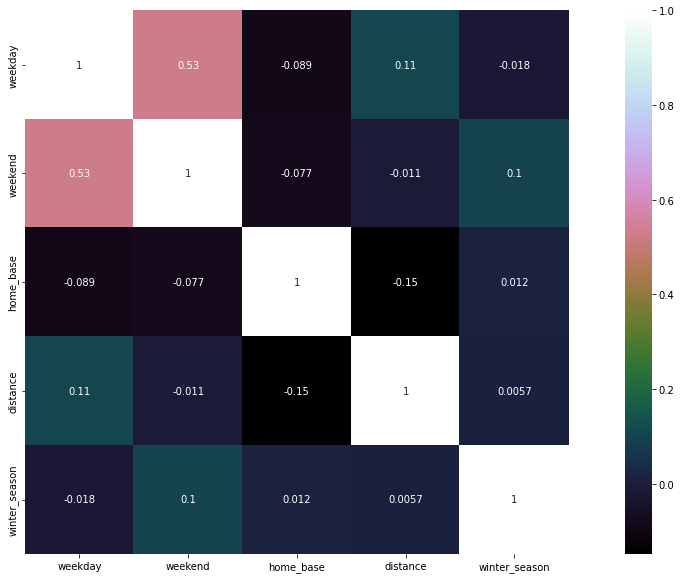

In [197]:

import matplotlib.pyplot as plt
import seaborn as sns
# GETTING Correllation matrix
corr_mat=X_train.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')

In [198]:
from sklearn.preprocessing import StandardScaler

X_Train=X_train.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)

Text(0, 0.5, 'Cumulative explained variance')

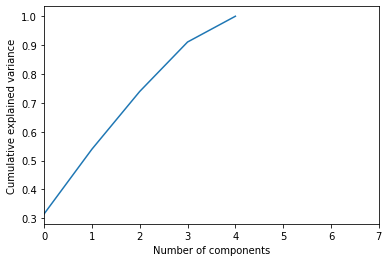

In [199]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/md/miniconda3/envs/leagues/lib/python3.7/site-packages/seaborn/distr

(-2.0, 2.0)

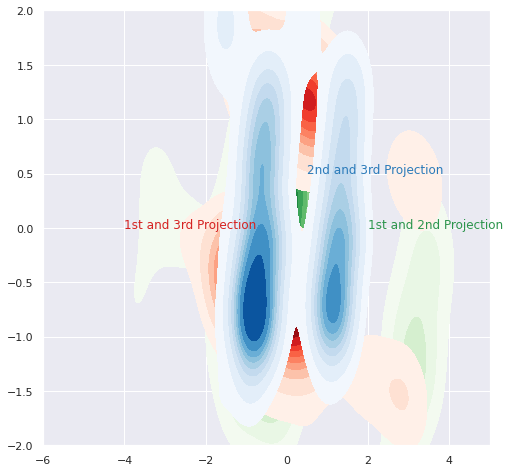

In [200]:
from sklearn.decomposition import PCA
sklearn_pca=PCA(n_components=5)
X_Train=sklearn_pca.fit_transform(X_std)

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(8, 8))
# ax.set_aspect('equal')
ax = sns.kdeplot(X_Train[:,0], X_Train[:,1], cmap="Greens",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,1], X_Train[:,2], cmap="Reds",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,2], X_Train[:,3], cmap="Blues",
          shade=True, shade_lowest=False)
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.5, 0.5, "2nd and 3rd Projection", size=12, color=blue)
ax.text(-4, 0.0, "1st and 3rd Projection", size=12, color=red)
ax.text(2, 0, "1st and 2nd Projection", size=12, color=green)
plt.xlim(-6,5)
plt.ylim(-2,2)

In [202]:
number_of_samples = len(y_train)
np.random.seed(0)
random_indices = np.random.permutation(number_of_samples)
num_training_samples = int(number_of_samples*0.75)
x_train = X_Train[random_indices[:num_training_samples]]
y_train=y[random_indices[:num_training_samples]]
x_test=X_Train[random_indices[num_training_samples:]]
y_test=y[random_indices[num_training_samples:]]
y_Train=list(y_train)

In [204]:
from sklearn import linear_model
model=linear_model.Ridge()
model.fit(x_train,y_train)
y_predict=model.predict(x_train)

error=0
for i in range(len(y_Train)):
    error+=(abs(y_Train[i]-y_predict[i])/y_Train[i])
train_error_ridge=error/len(y_Train)*100
print("Train error = "'{}'.format(train_error_ridge)+" percent in Ridge Regression")

Y_test=model.predict(x_test)
y_Predict=list(y_test)

error=0
for i in range(len(y_test)):
    error+=(abs(y_Predict[i]-Y_test[i])/y_Predict[i])
test_error_ridge=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_ridge)+" percent in Ridge Regression")

Train error = 98.44699684022491 percent in Ridge Regression
Test error = 99.98330172684955 percent in Ridge Regression


Text(0.5, 1.0, 'Residual plot in Ridge Regression')

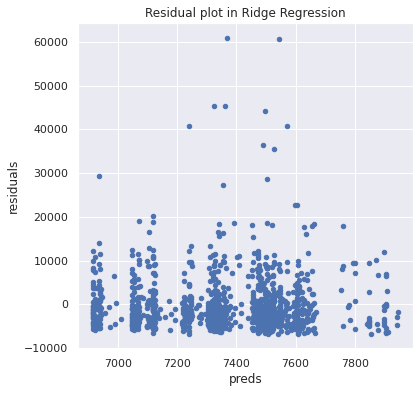

In [206]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Ridge Regression")

In [208]:
from sklearn import neighbors
n_neighbors=5
knn=neighbors.KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(x_train,y_train)
y1_knn=knn.predict(x_train)
y1_knn=list(y1_knn)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_knn[i]-y_Train[i])/y_Train[i])
train_error_knn=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_knn)+" percent"+" in Knn algorithm")

y2_knn=knn.predict(x_test)
y2_knn=list(y2_knn)
error=0
for i in range(len(y_test)):
    error+=(abs(y2_knn[i]-Y_test[i])/Y_test[i])
test_error_knn=error/len(Y_test)*100
print("Test error = "'{}'.format(test_error_knn)+" percent"+" in knn algorithm")

Train error = 93.27939871725515 percent in Knn algorithm
Test error = 34.00485323676349 percent in knn algorithm


In [209]:
reg = linear_model.BayesianRidge()
reg.fit(x_train,y_train)
y1_reg=reg.predict(x_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_reg[i]-y_Train[i])/y_Train[i])
train_error_bay=error/len(y_Train)*100
print("Train error = "+'{}'.format(train_error_bay)+" percent"+" in Bayesian Regression")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_reg[i]-Y_test[i])/Y_test[i])
test_error_bay=(error/len(Y_test))*100
print("Test error = "+'{}'.format(test_error_bay)+" percent"+" in Bayesian Regression")

Train error = 98.42901599605693 percent in Bayesian Regression
Test error = 2.6273348309846623 percent in Bayesian Regression


In [236]:
from sklearn.tree import DecisionTreeRegressor 

dec = DecisionTreeRegressor(max_depth=5, random_state=1234)
dec.fit(X_train,y_train)
y1_dec=dec.predict(X_train)
y1_dec=list(y1_dec)
y2_dec=dec.predict(X_test)
y2_dec=list(y2_dec)

error=0
for i,v in enumerate(y_train):
    error+=(abs(y1_dec[i]-v)/v)
train_error_tree=error/len(y_train)*100
print("Train error = "+'{}'.format(train_error_tree)+" percent"+" in Decision Tree Regressor")

error=0
for i,v in enumerate(y_test):
    error+=(abs(y1_dec[i]-v)/v)
test_error_tree=error/len(y_test)*100
print("Test error = "'{}'.format(test_error_tree)+" percent in Decision Tree Regressor")

Train error = 45.1440475751096 percent in Decision Tree Regressor
Test error = 115.23229120765764 percent in Decision Tree Regressor


In [240]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Predicting the SalePrices using test set 
y_pred_lr = lin_reg.predict(X_test)

#Mutiple Linear Regression Accuracy with test set
accuracy_lf = metrics.r2_score(y_test, y_pred_lr)
print('Mutiple Linear Regression Accuracy: ', accuracy_lf)

#Predicting the SalePrice using cross validation (KFold method)
y_pred_kf_lr = cross_val_predict(lin_reg, X, y, cv=10 )

#Mutiple Linear Regression Accuracy with cross validation (KFold method)
accuracy_lf = metrics.r2_score(y, y_pred_kf_lr)
print('Cross-Predicted(KFold) Mutiple Linear Regression Accuracy: ', accuracy_lf)

Mutiple Linear Regression Accuracy:  0.3760362035902819
Cross-Predicted(KFold) Mutiple Linear Regression Accuracy:  0.26323368310834494


In [241]:
poly_reg = PolynomialFeatures(degree = 2)
X_poly = poly_reg.fit_transform(X)
lin_reg_pl = LinearRegression()

#Predicting the SalePrice using cross validation (KFold method)
y_pred_pl = cross_val_predict(lin_reg_pl, X_poly, y, cv=10 )
#Polynominal Regression Accuracy with cross validation
accuracy_pl = metrics.r2_score(y, y_pred_pl)
print('Cross-Predicted(KFold) Polynominal Regression Accuracy: ', accuracy_pl)

Cross-Predicted(KFold) Polynominal Regression Accuracy:  0.2973208431334121


In [242]:
dt_regressor = DecisionTreeRegressor(random_state = 0)
dt_regressor.fit(X_train,y_train)

#Predicting the SalePrices using test set 
y_pred_dt = dt_regressor.predict(X_test)

#Decision Tree Regression Accuracy with test set
print('Decision Tree Regression Accuracy: ', dt_regressor.score(X_test,y_test))

#Predicting the SalePrice using cross validation (KFold method)
y_pred_dt = cross_val_predict(dt_regressor, X, y, cv=10 )
#Decision Tree Regression Accuracy with cross validation
accuracy_dt = metrics.r2_score(y, y_pred_dt)
print('Cross-Predicted(KFold) Decision Tree Regression Accuracy: ', accuracy_dt)

Decision Tree Regression Accuracy:  0.41316821537538995
Cross-Predicted(KFold) Decision Tree Regression Accuracy:  0.43545963056661785


In [243]:
rf_regressor = RandomForestRegressor(n_estimators = 300 ,  random_state = 0)
rf_regressor.fit(X_train,y_train)

#Predicting the SalePrices using test set 
y_pred_rf = rf_regressor.predict(X_test)

#Random Forest Regression Accuracy with test set
print('Random Forest Regression Accuracy: ', rf_regressor.score(X_test,y_test))

#Predicting the SalePrice using cross validation (KFold method)
y_pred_rf = cross_val_predict(rf_regressor, X, y, cv=10 )

#Random Forest Regression Accuracy with cross validation
accuracy_rf = metrics.r2_score(y, y_pred_rf)
print('Cross-Predicted(KFold) Random Forest Regression Accuracy: ', accuracy_rf)

Random Forest Regression Accuracy:  0.5152096358767789
Cross-Predicted(KFold) Random Forest Regression Accuracy:  0.5008508177441224


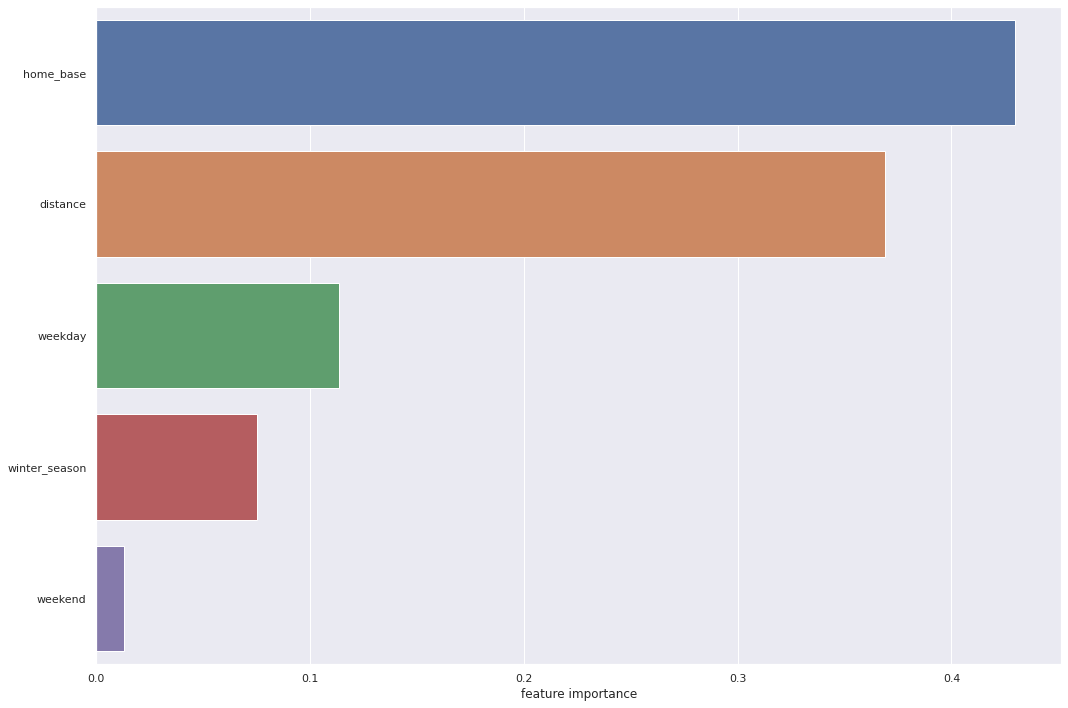

In [245]:
ranking = np.argsort(-rf_regressor.feature_importances_)
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=rf_regressor.feature_importances_[ranking], y=X_train.columns.values[ranking], orient='h')
ax.set_xlabel("feature importance")
plt.tight_layout()
plt.show()

In [246]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

#Predicting the SalePrices using test set 
y_pred_lr = lin_reg.predict(X_test)

#Mutiple Linear Regression Accuracy with test set
accuracy_lf = metrics.r2_score(y_test, y_pred_lr)
print('Mutiple Linear Regression Accuracy: ', accuracy_lf)

#Predicting the SalePrice using cross validation (KFold method)
y_pred_kf_lr = cross_val_predict(lin_reg, X, y, cv=10 )

#Mutiple Linear Regression Accuracy with cross validation (KFold method)
accuracy_lf = metrics.r2_score(y, y_pred_kf_lr)
print('Cross-Predicted(KFold) Mutiple Linear Regression Accuracy: ', accuracy_lf)

Mutiple Linear Regression Accuracy:  0.3760362035902819
Cross-Predicted(KFold) Mutiple Linear Regression Accuracy:  0.26323368310834494
